<a href="https://colab.research.google.com/github/9terry-student/pytorch/blob/main/6_Multi_Layer_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
# 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

In [98]:
# 문장->토큰화->토큰ID
sentence="I went to the hospital"
tokens=sentence.lower().split()
print("tokens:",tokens)

vocab={w:i for i,w in enumerate(tokens)}
print("vocab:",vocab)

token_ids=torch.tensor([[vocab[w] for w in tokens]])    # (B=1,S=5)
print("token_ids:",token_ids)




tokens: ['i', 'went', 'to', 'the', 'hospital']
vocab: {'i': 0, 'went': 1, 'to': 2, 'the': 3, 'hospital': 4}
token_ids: tensor([[0, 1, 2, 3, 4]])


In [99]:
# Embedding
B,S=token_ids.shape
D=8

embedding=nn.Embedding(len(vocab),D)
x=embedding(token_ids)
print("embedding output shape:",x.shape)

embedding output shape: torch.Size([1, 5, 8])


In [100]:
# Positional Encoding
def positional_encoding(seq_len,embed_dim):
  pe=torch.zeros(seq_len,embed_dim)
  for pos in range(seq_len):
    for i in range(0,embed_dim,2):
      pe[pos,i]=math.sin(pos/(10000**(i/embed_dim)))
      pe[pos,i+1]=math.cos(pos/(10000**(i/embed_dim)))
  return pe

pe=positional_encoding(S,D).unsqueeze(0)    # (1,S,D)
x=x+pe    # 위치 정보 추가
print("after positional encoding:",x.shape)

after positional encoding: torch.Size([1, 5, 8])


In [101]:
# Multi-Head Attention
class MultiHeadAttention(nn.Module):
  def __init__(self,embed_dim,num_heads):
    super().__init__()
    assert embed_dim%num_heads==0, "D는 head 수로 나누어 떨어져야 함"
    self.num_heads=num_heads
    self.head_dim=embed_dim//num_heads

    # Q,K,V를 전체 D에서 한 번에 만들기
    self.q=nn.Linear(embed_dim,embed_dim)
    self.k=nn.Linear(embed_dim,embed_dim)
    self.v=nn.Linear(embed_dim,embed_dim)

    self.out=nn.Linear(embed_dim,embed_dim)

  def forward(self,x):
    B,S,D=x.shape

    # Q,K,V shape: (B,S,D)
    Q=self.q(x)
    K=self.k(x)
    V=self.v(x)

    # Multi-Head로 나누기: (B,head,S,head_dim)
    Q=Q.view(B,S,self.num_heads,self.head_dim).transpose(1,2)
    K=K.view(B,S,self.num_heads,self.head_dim).transpose(1,2)
    V=V.view(B,S,self.num_heads,self.head_dim).transpose(1,2)

    # Attention 계산
    scores=Q@K.transpose(-2,-1)/(self.head_dim**0.5)
    weights=F.softmax(scores,dim=-1)
    out=weights@V   # (B,head,S,head_dim)

    # 다시 합치기
    out=out.transpose(1,2).contiguous().view(B,S,D)
    out=self.out(out)
    return out,weights

In [102]:
# MiniEncoder Layer
class MiniEncoder(nn.Module):
  def __init__(self,embed_dim,num_heads):
    super().__init__()
    self.mha=MultiHeadAttention(embed_dim,num_heads)
    self.norm1=nn.LayerNorm(embed_dim)
    self.norm2=nn.LayerNorm(embed_dim)

    self.ff=nn.Sequential(
        nn.Linear(embed_dim,4*embed_dim),
        nn.ReLU(),
        nn.Linear(4*embed_dim,embed_dim)
    )
  def forward(self,x):
    # Multi-Head+Residual+LayerNorm
    attn_out,weights=self.mha(x)
    x=self.norm1(x+attn_out)

    # FeedForward+Residual+LayerNorm
    ff_out=self.ff(x)
    x=self.norm2(x+ff_out)

    return x,weights

In [103]:
# Multi-Layer Encoder
class EncoderStack(nn.Module):
  def __init__(self,embed_dim,num_heads,num_layers):
    super().__init__()
    self.layers=nn.ModuleList([
        MiniEncoder(embed_dim,num_heads)
        for _ in range(num_layers)
    ])

  def forward(self,x):
    all_attn=[]
    for layer in self.layers:
      x,attn=layer(x)
      all_attn.append(attn)
    return x,all_attn

In [104]:
# Encoder 실행
encoder=EncoderStack(
    embed_dim=D,num_heads=2,
    num_layers=3
)

output,attn_weights=encoder(x)

print("final output shape:",output.shape)
print("number of layers:",len(attn_weights))

final output shape: torch.Size([1, 5, 8])
number of layers: 3


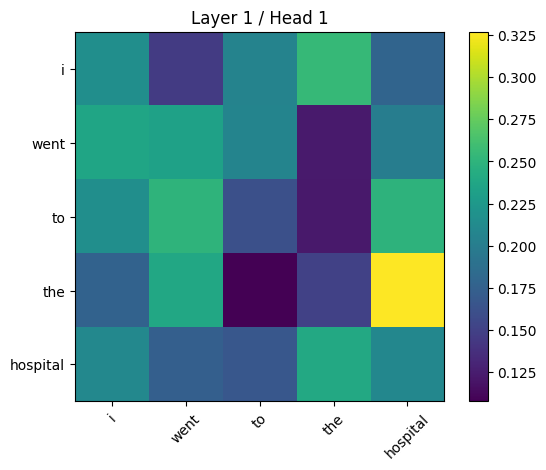

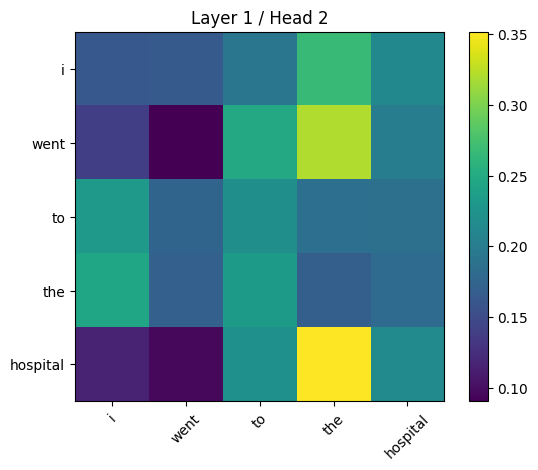

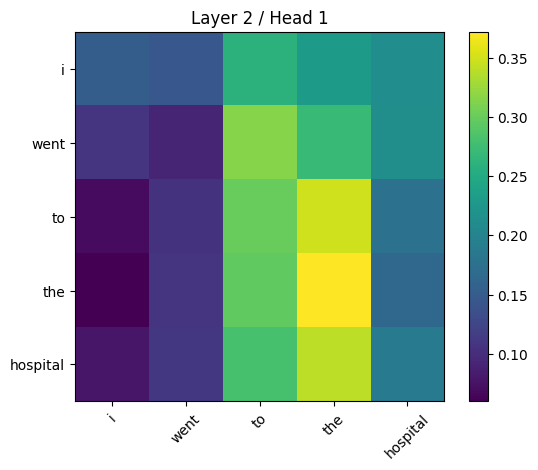

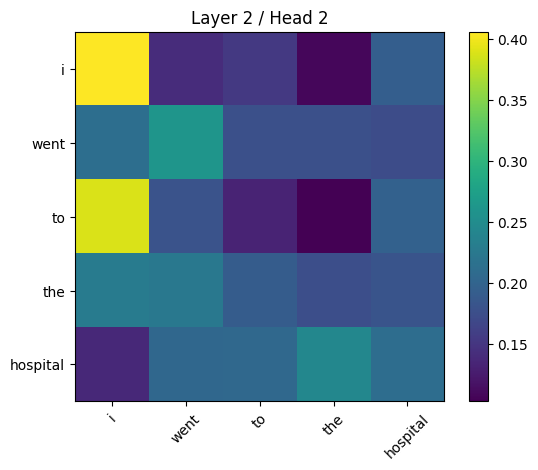

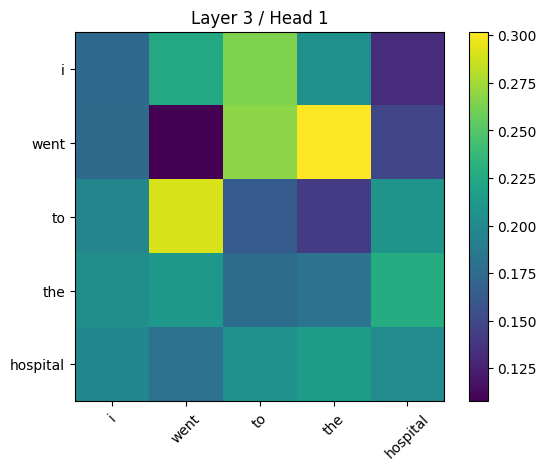

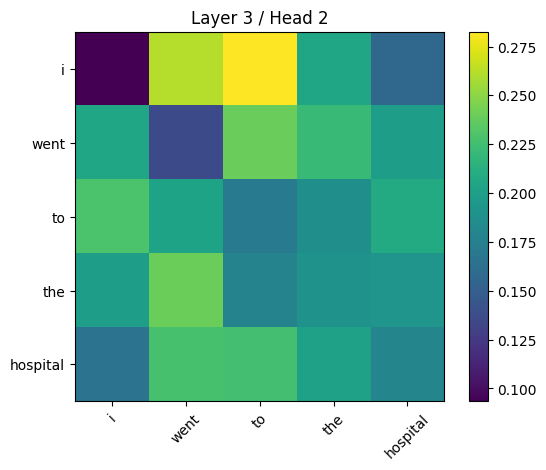

In [105]:
# Attention 히트맵 (Layer별 + Head별)
for layer_idx,layer_attn in enumerate(attn_weights):
  for head in range(layer_attn.shape[1]):
    plt.figure()
    plt.imshow(layer_attn[0,head].detach().numpy())
    plt.xticks(range(S),tokens,rotation=45)
    plt.yticks(range(S),tokens)
    plt.colorbar()
    plt.title(f"Layer {layer_idx+1} / Head {head+1}")
    plt.show()